# ch1 简单车道线检测


## p1:color selection

1.通过阈值过滤

2.区域选择


## np.meshgrid(x, y)用法

In [1]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array([0, 1, 2])
y = np.array([0, 1])

X, Y = np.meshgrid(x, y)
print(X)
print(Y)


plt.plot(X, Y,
         color='red',  # 全部点设置为红色
         marker='.',  # 点的形状为圆点
         linestyle='')  # 线型为空，也即点与点之间不用线连接
plt.grid(True)
plt.show()


[[0 1 2]
 [0 1 2]]
[[0 0 0]
 [1 1 1]]


(500, 1000)
(500, 1000)


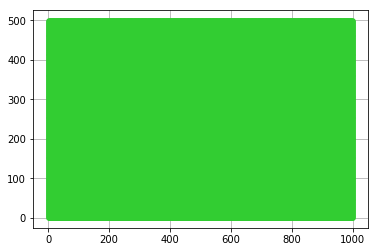

In [2]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0,1000,1000)
#print(x)
y = np.linspace(0,500,500)

X,Y = np.meshgrid(x, y)
print(X.shape)
print(Y.shape)
plt.plot(X, Y,
         color='limegreen',  # 设置颜色为limegreen
         marker='.',  # 设置点类型为圆点
         linestyle='')  # 设置线型为空，也即没有线连接点
plt.grid(True)
plt.show()


## np.polyfit()用法

# p2. 边缘检测

### cv2.GaussianBlur()用法

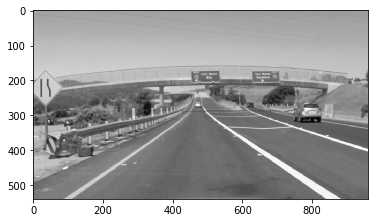

In [3]:
#doing all the relevant imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

# Read in the image and convert to grayscale
image = mpimg.imread('./images/exit-ramp.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Define a kernel size for Gaussian smoothing / blurring
# Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)
plt.imshow(blur_gray, cmap='Greys_r')
plt.show()

### cv2.Canny()边缘检测

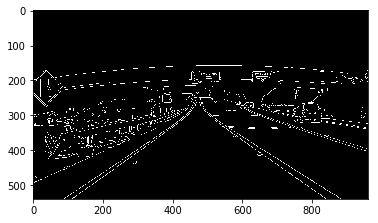

In [4]:
# Define parameters for Canny and run it
# NOTE: if you try running this code you might want to change these!
low_threshold = 80
high_threshold = low_threshold*2
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Display the image
plt.imshow(edges, cmap='Greys_r')
plt.show()

### cv2.fillPoly() 填充多边形

cv2.fillPoly()函数可以用来填充任意形状的图型.可以用来绘制多边形,

工作中也经常使用非常多个边来近似的画一条曲线.

cv2.fillPoly()函数可以一次填充多个图型.

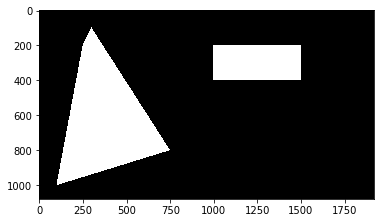

In [5]:
img = np.zeros((1080, 1920, 3), np.uint8)
area1 = np.array([[250, 200], [300, 100], [750, 800], [100, 1000]])
area2 = np.array([[1000, 200], [1500, 200], [1500, 400], [1000, 400]])

cv2.fillPoly(img, [area1, area2], (255, 255, 255))

plt.imshow(img)
plt.show()

### cv2.bitwise_and() 与操作

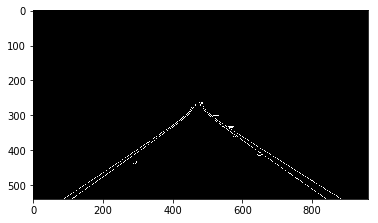

In [6]:
# Next we'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(edges)   
ignore_mask_color = (255,)* 3


left_bottom = [100, 550]
right_bottom = [850, 550]
apex = [450, 300]

# This time we are defining a four sided polygon to mask
imshape = image.shape
#vertices = np.array([[(50,imshape[0]),(0, 0), (imshape[1], 0), (imshape[1],imshape[0])]], dtype=np.int32)
vertices = np.array([[(80,imshape[0]),(480, 260),(500, 260), (900,imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)
plt.imshow(masked_edges, cmap='Greys_r')
plt.show()

# p3. 霍夫变换

cv2.HoughLinesP():霍夫变换,寻找直线

cv2.line()：画线

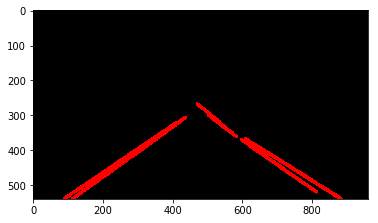

In [7]:
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 5     # minimum number of votes (intersections in Hough grid cell)
min_line_length =60 #minimum number of pixels making up a line
max_line_gap = 10    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on a blank image
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 
plt.imshow(line_image)
plt.show()

### cv2.addWeighted()

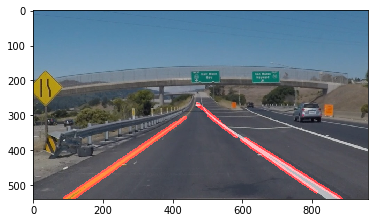

In [8]:
# Draw the lines on the edge image
lines_edges = cv2.addWeighted(image, 0.8, line_image, 1, 0) 
plt.imshow(lines_edges)
plt.show()

# ch2 高级视觉

the first step is to sense or perceive the world.

the second step is to decide what to do based on that perception.

and the third step is to perform an action to carry out that decision.

radar and lidar see the world in 3D



从真实世界三维坐标到二维图像坐标的变换矩阵，叫做相机矩阵；

失真的类型：

1.radial distortion:真实相机用弯曲镜头来成像，光线在镜头边缘处经常弯曲，称为径向失真；

2.tangential distortion:切向失真，镜头未完全平行于成像面时，使得图像看起来倾斜；





![avatar](./images/distortion_radial.png)



失真系数和矫正：

1.radial distortion系数有三个：k1,k2 and k3. 可以使用矫正公式校正径向扭曲了图像；


Distortion_coefficients = (k1 k2 p1 p2 k3)一般用五个参数可以消除失真；

![avatar](./images/distortion_radial2.png)

## P1 畸变矫正

用到的opencv函数

1.得到灰度图

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

2.Finding chessboard corners (for an 8x6 board):

ret, corners = cv2.findChessboardCorners(gray, (8,6), None)


3.Drawing detected corners on an image:

img = cv2.drawChessboardCorners(img, (8,6), corners, ret)


4.标定相机Camera calibration

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

objpoints:对象点坐标，3D points in real world space

imgpoints:图像点坐标，2D points in image plane


5.图像矫正：Undistorting a test image:

dst = cv2.undistort(img, mtx, dist, None, mtx)




### sample1 角点检测


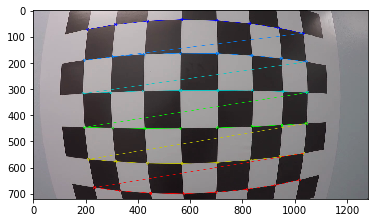

In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# prepare object points
nx = 8#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y

# Make a list of calibration images
fname = './images/calibration_test.png'
img = cv2.imread(fname)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)
    plt.show()

### sample2 标定相机，畸变矫正

In [10]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in the saved objpoints and imgpoints
dist_pickle = pickle.load( open( "lesson5/wide_dist_pickle.p", "rb" ) )
objpoints = dist_pickle["objpoints"]  #3D points in real world space,对象点位置
imgpoints = dist_pickle["imgpoints"]  #2D，角点在图像的实际坐标

print(len(objpoints),objpoints[0].shape)  #35张图，每张图48个点
print(len(imgpoints),imgpoints[0].shape)  #35张图，每张图48个点，每个点，x,y坐标

35 (48, 3)
35 (48, 1, 2)


In [11]:
# TODO: Write a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    img_size = (img.shape[1],img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,img_size,None,None)
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    #undist = np.copy(img)  # Delete this line
    return undist

# Read in an image
img = cv2.imread('lesson5/test_image.png')
print(img.shape)
undistorted = cal_undistort(img, objpoints, imgpoints)



(960, 1280, 3)


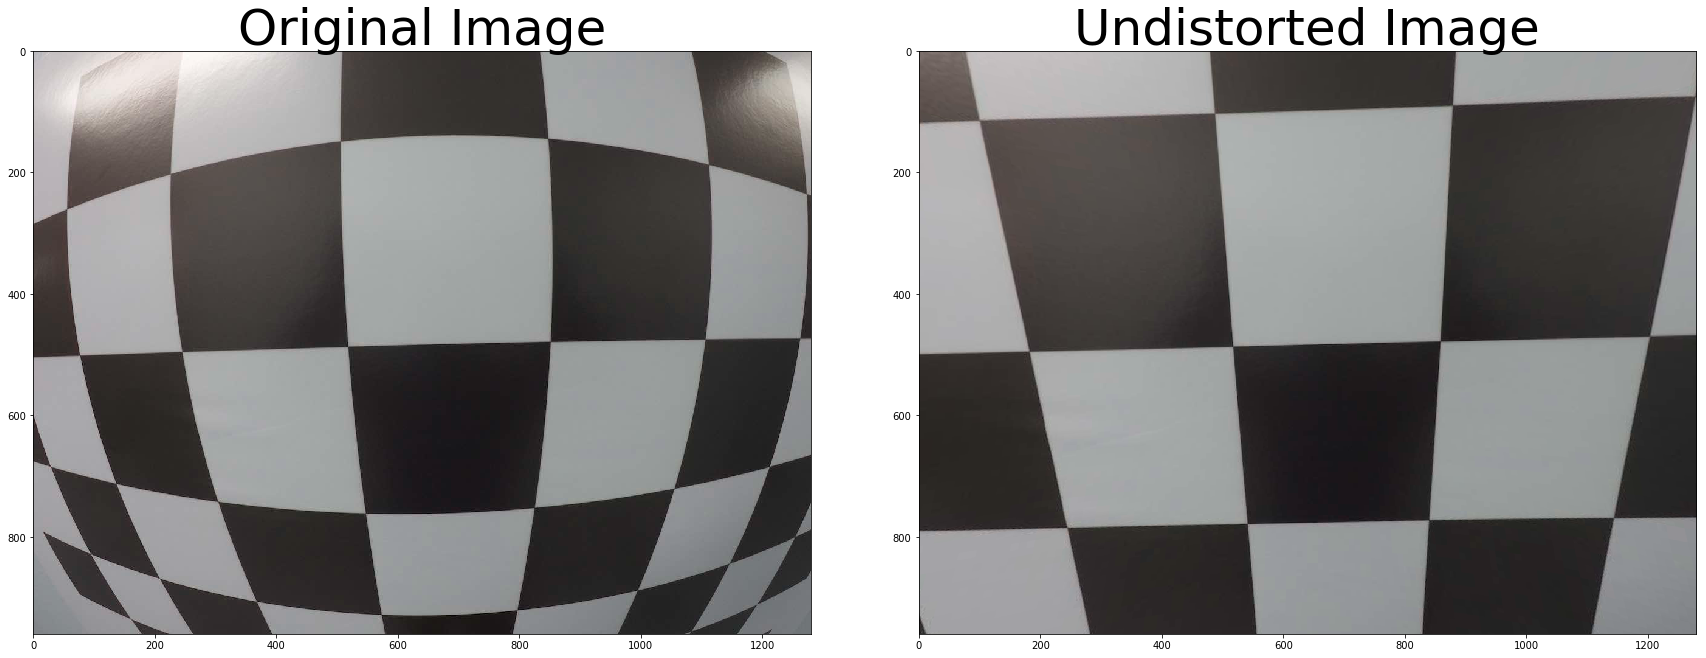

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

## P2 Perspective,视角转化

Perspective用到的opencv函数：

1.计算转换矩阵

M = cv2.getPerspectiveTransform(src, dst)

2.转换你矩阵

Minv = cv2.getPerspectiveTransform(dst, src)

3.用转换矩阵，转化图像

warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

In [13]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [18]:
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "lesson5/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# MODIFY THIS FUNCTION TO GENERATE OUTPUT 
# THAT LOOKS LIKE THE IMAGE ABOVE
def corners_unwarp(img, nx, ny, mtx, dist):
    # Pass in your image into this function
    # Write code to do the following steps
    
    # 1) Undistort using mtx and dist
    img_size = (img.shape[1],img.shape[0])
    undist_img = cv2.undistort(img,mtx,dist,None,mtx)
    #plt.imshow(undist_img)
    
    # 2) Convert to grayscale
    gray = cv2.cvtColor(undist_img,cv2.COLOR_BGR2GRAY)
    #plt.imshow(gray,cmap='gray')
    #print(img_size)
    
    # 3) Find the chessboard corners
    #Convert image to grayscale
    ret, corners = cv2.findChessboardCorners(gray,(nx,ny),None)

    # 4) If corners found: 
            # a) draw corners
            # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
                 #Note: you could pick any four of the detected corners 
                 # as long as those four corners define a rectangle
                 #One especially smart way to do this would be to use four well-chosen
                 # corners that were automatically detected during the undistortion steps
                 #We recommend using the automatic detection of corners in your code
            # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
            # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
            # e) use cv2.warpPerspective() to warp your image to a top-down view
            
    if ret == True:
        img_new = cv2.drawChessboardCorners(undist_img,(nx, ny),corners,ret)
        plt.imshow(img_new)
        print(type(corners),corners.shape)
        #print(corners)
        
        offset = 120
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        
        #delete the next two lines
        M = cv2.getPerspectiveTransform(src,dst)
        #warped = np.copy(img) 
        warped = cv2.warpPerspective(undist_img,M,img_size,flags=cv2.INTER_LINEAR)
    else:
        print("find corners failded")
    #b)
    
    return warped, M

<class 'numpy.ndarray'>
<class 'numpy.ndarray'> (48, 1, 2)


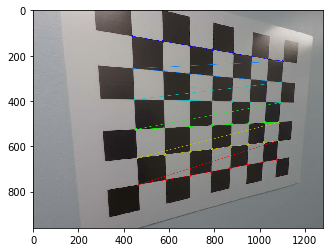

In [25]:
# Read in an image
img = cv2.imread('images/test_image2.png')
print(type(img))
nx = 8 # the number of inside corners in x
ny = 6 # the number of inside corners in y
top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)

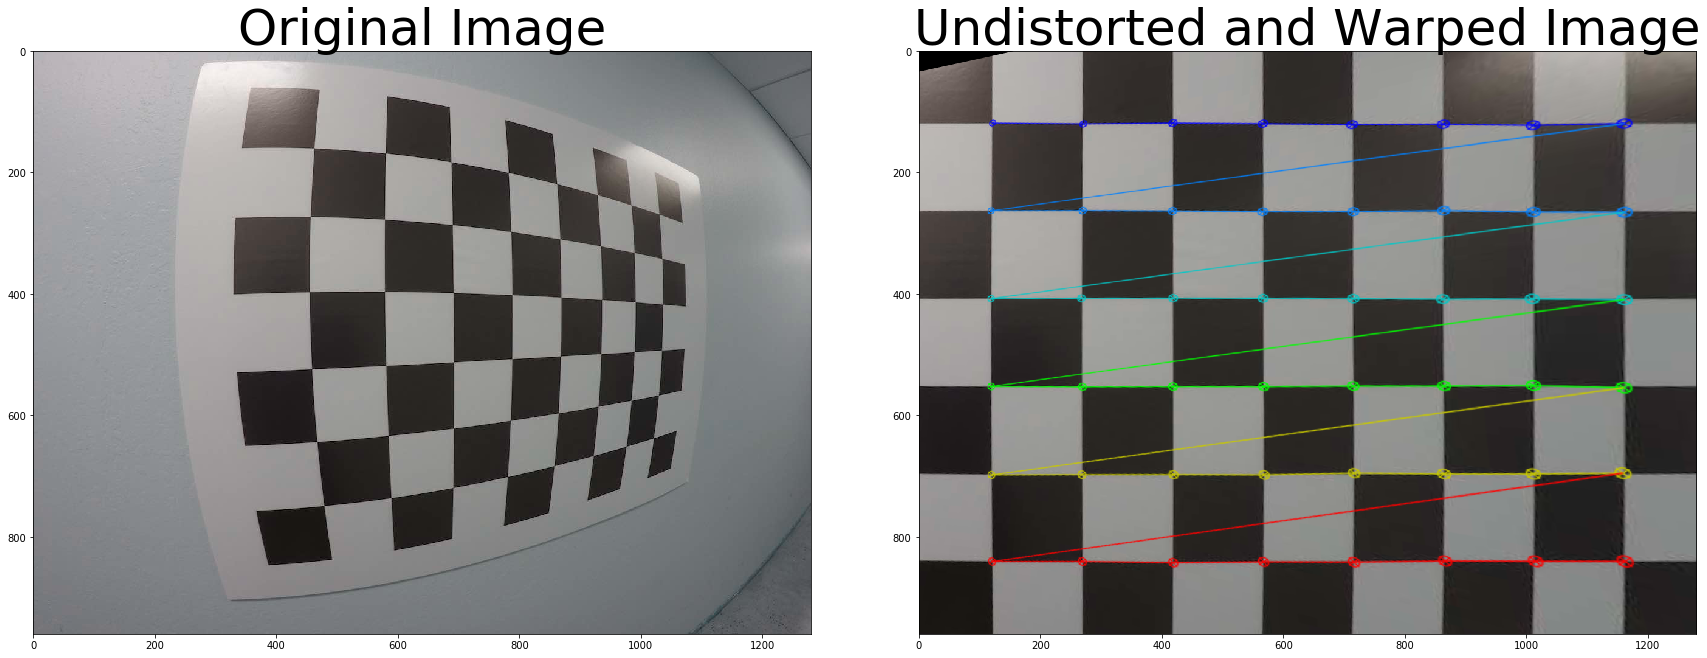

In [26]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# ch8 梯度和色彩空间

## part1 sobel算子

canny适合寻找图片中所有的边缘线

车道线是近似垂直线，可以利用sobel在x方向的求梯度

![avatar](./images/sobel1.png)

kernel_size=3是最小的内核大小，实际上可以设任何奇数(偶数的话，得中间值0.5,在差分像素点中会落到０点)；

较大的内核，采取更平滑的梯度；

![avatar](./images/sobel2.png)

如果图像水平方向是平滑的，积分和就是０


### sobel　x/y效果图

![avatar](./images/sobel_x_y.png)

### sobel算子用到的opencv函数

1.gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)　＃sobel算子处理灰度图

Note: Make sure you use the correct grayscale conversion depending on how you've read in your images. Use cv2.COLOR_RGB2GRAY if you've read in an image using mpimg.imread(). Use cv2.COLOR_BGR2GRAY if you've read in an image using cv2.imread().

2.求x方向的导数

sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)

3.求y方向的导数

sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)

4.Calculate the absolute value of the x derivative:

abs_sobelx = np.absolute(sobelx)

5.Convert the absolute value image to 8-bit:

scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))


### part2 magnitude梯度的度量

magnitude实际上是x,y方向的梯度平方和的平方根

可以修改sobel核的大小，以改变应用渐变的区域大小；

## sobel梯度的几种计算方法


In [27]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

In [30]:
# Read in an image
image = mpimg.imread('images/signs_vehicles_xygrad.png')

In [31]:
def abs_sobel_thresh(img, orient,sobel_kernel=3,thresh=(0,255)):
    thresh_min,thresh_max= thresh
    print(thresh_min,thresh_max)
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    if orient =='x':
        abs_sobel = np.absolute(cv2.Sobel(gray,cv2.CV_64F,1,0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray,cv2.CV_64F,0,1))
    
    #print(abs_sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    #print(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return binary_output

### 1.求x/y方向导数

20 100
20 100


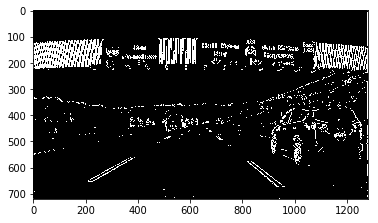

In [34]:
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
plt.imshow(gradx,cmap='gray')

### 2. Magnitude of the Gradient梯度

像素点x/y方向导数的平方和，开方

$abs\_sobelx = \sqrt[]{(sobel_x)^{2}}$

$abs\_sobely = \sqrt[]{(sobel_y)^{2}}$

$abs\_sobelxy = \sqrt[]{(sobel_x)^{2}+(sobel_y)^{2}}$


In [35]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #plt.imshow(gray,cmap='gray')
    
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(sobel_x**2 + sobel_y**2)
    #print(gradmag.shape)
    #print(gradmag)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(gradmag)
    
    # 6) Return this mask as your binary_output image
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

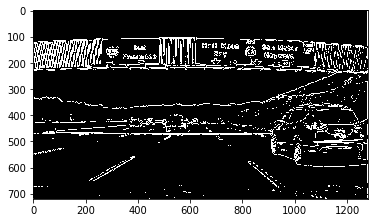

In [37]:
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
plt.imshow(mag_binary, cmap='gray')

3.方向梯度

The direction of the gradient is simply the inverse tangent (arctangent) of the yy gradient divided by the xx gradient:

$arctan(sobel_y/sobel_x)$


$abs\_grad\_dir = np.arctan2(np.absolute(sobel\_y),np.absolute(sobel\_x))$

In [38]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    abs_grad_dir = np.arctan2(np.absolute(sobel_y),np.absolute(sobel_x))
    
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(abs_grad_dir)
    
    # 6) Return this mask as your binary_output image
    binary_output[(abs_grad_dir >= thresh[0]) & (abs_grad_dir <= thresh[1])] = 1
    
    
    return binary_output

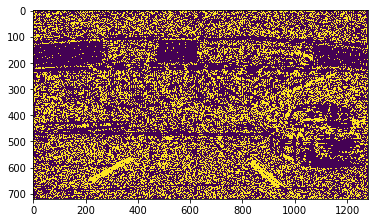

In [39]:
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
plt.imshow(dir_binary)

# 实际工程中，可以取上述多个方法的综合



In [40]:
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

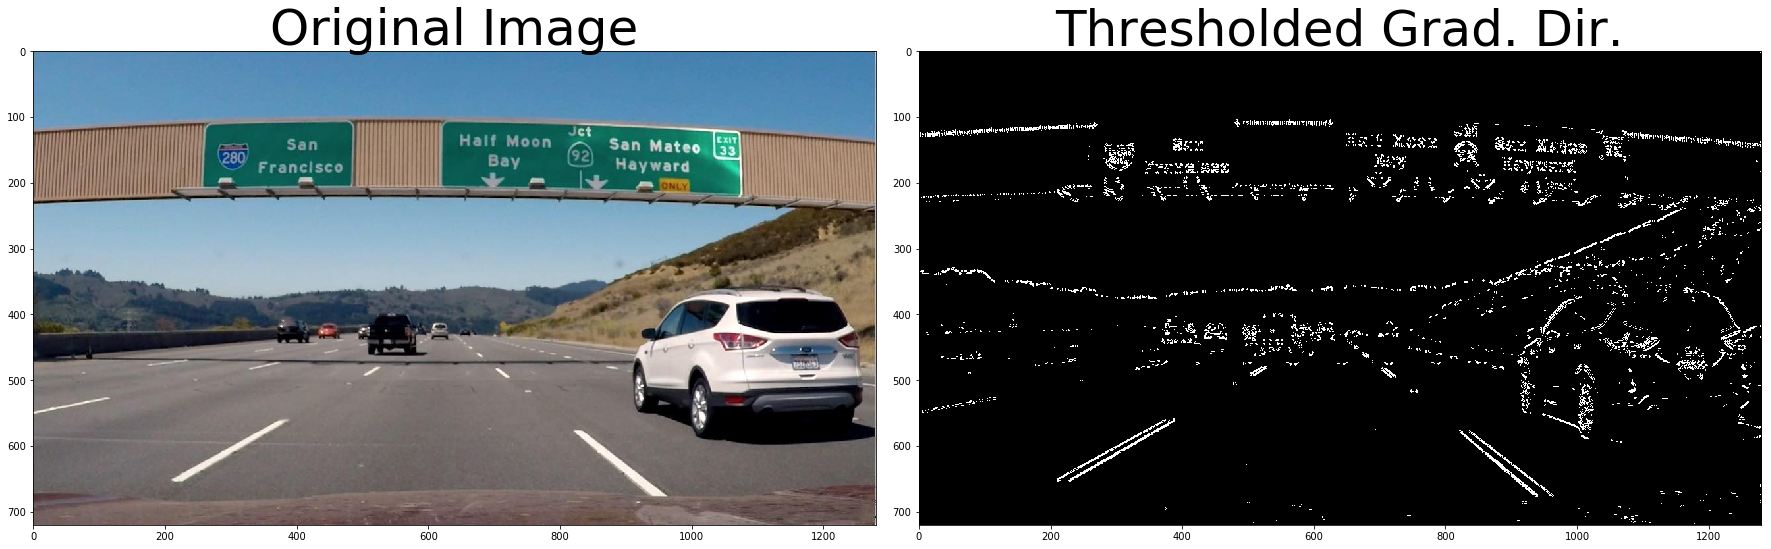

In [42]:
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## part2 色彩空间

![avatar](./images/color_space_rgb.png)

![avatar](./images/color_space_hsv_hls.png)

RGB不能处理所有颜色，比如当车道线是黄色的时候，在阴暗环境下，颜色信息丢失；

这时取ＨＬＳ颜色空间Ｓ信号，对光线条件不敏感；


In [80]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

# Read in an image, you can also try test1.jpg or test4.jpg
image = mpimg.imread('images/test4.jpg') 

In [128]:
def rgb_select(img, thresh=(0, 255)):
    #gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    print(img.shape)
    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]
        
    # Plot the result
    f, axes = plt.subplots(1, 4, figsize=(24, 9))
    f.tight_layout()
    
    axes[0].imshow(r)
    axes[0].set_title('Original Image', fontsize=50)
    
    axes[1].imshow(r,cmap = 'gray')
    axes[1].set_title('R', fontsize=50)
    
    axes[2].imshow(g,cmap='gray')
    axes[2].set_title('G', fontsize=50)
    
    axes[3].imshow(b,cmap='gray')
    axes[3].set_title('B', fontsize=50)

(720, 1280, 3)


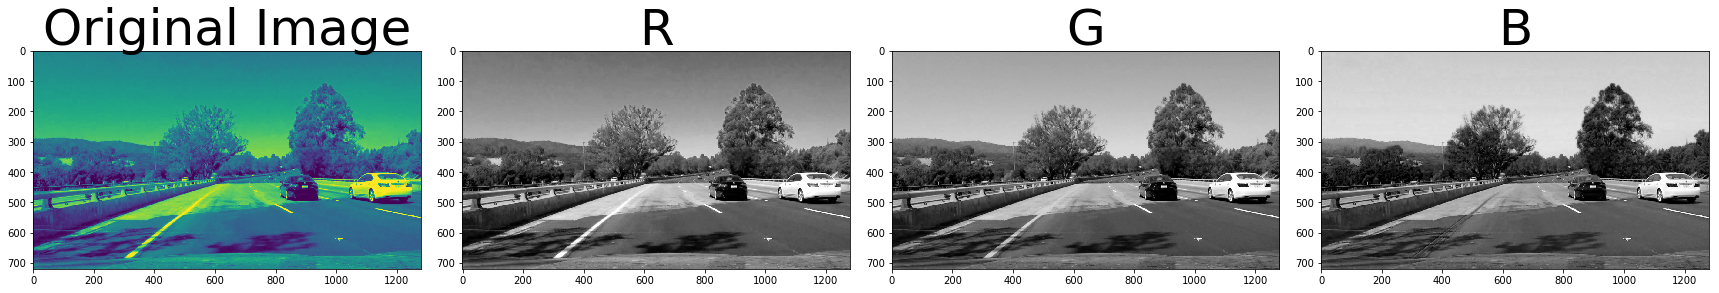

In [129]:
rgb_binary = rgb_select(image, thresh=(10, 255))

## 

In [116]:
# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls_img = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    
    # 2) Apply a threshold to the S channel
    s_val = hls_img[:,:,2]
    plt.imshow(s_val)
    # 3) Return a binary image of threshold result
    binary_output = np.zeros_like(s_val)
    binary_output[(s_val > thresh[0]) & (s_val <= thresh[1])] = 1
    
    return binary_output


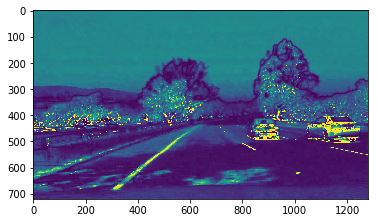

In [117]:
hls_binary = hls_select(image, thresh=(90, 255))

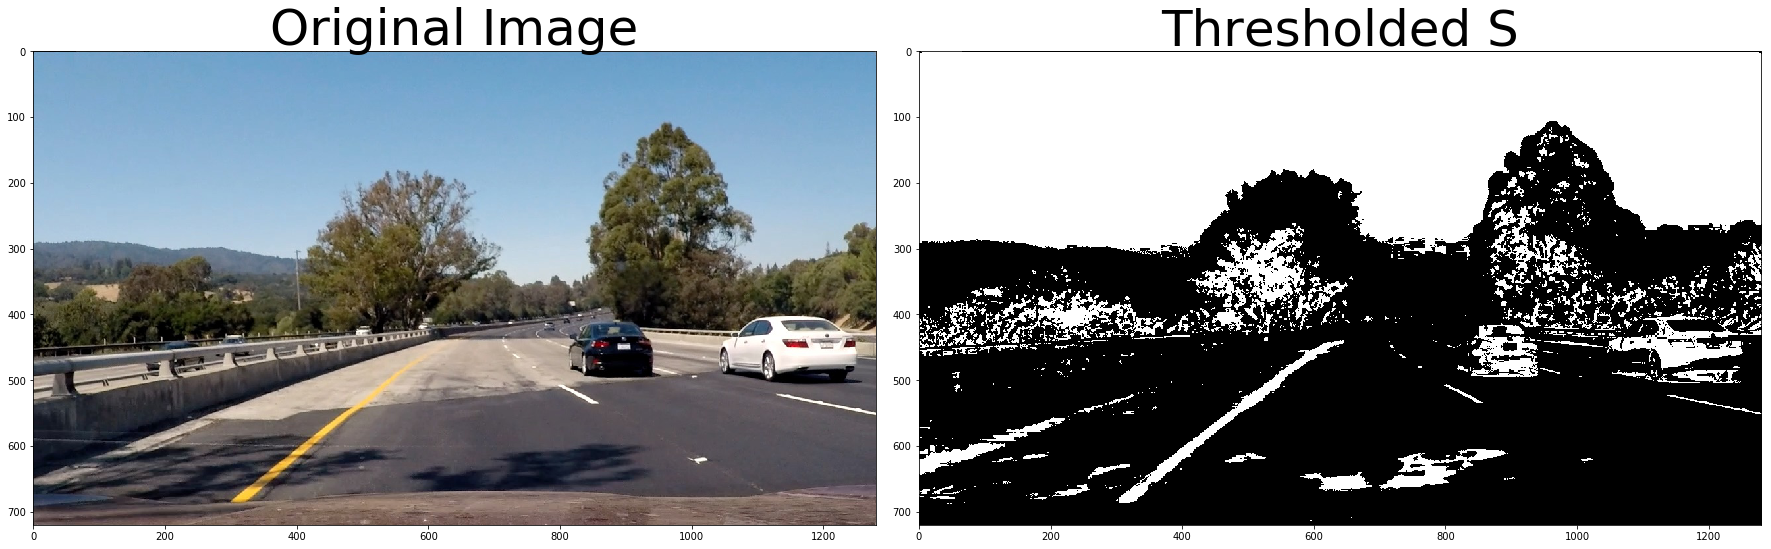

In [130]:
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 综合多种方法检测车道线

![avatar](./images/combined_color_and_gradient_thresholds.png)

In [135]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('images/bridge_shadow.jpg')

In [136]:
# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    return color_binary

In [137]:
result = pipeline(image,s_thresh=(170, 255), sx_thresh=(20, 100))

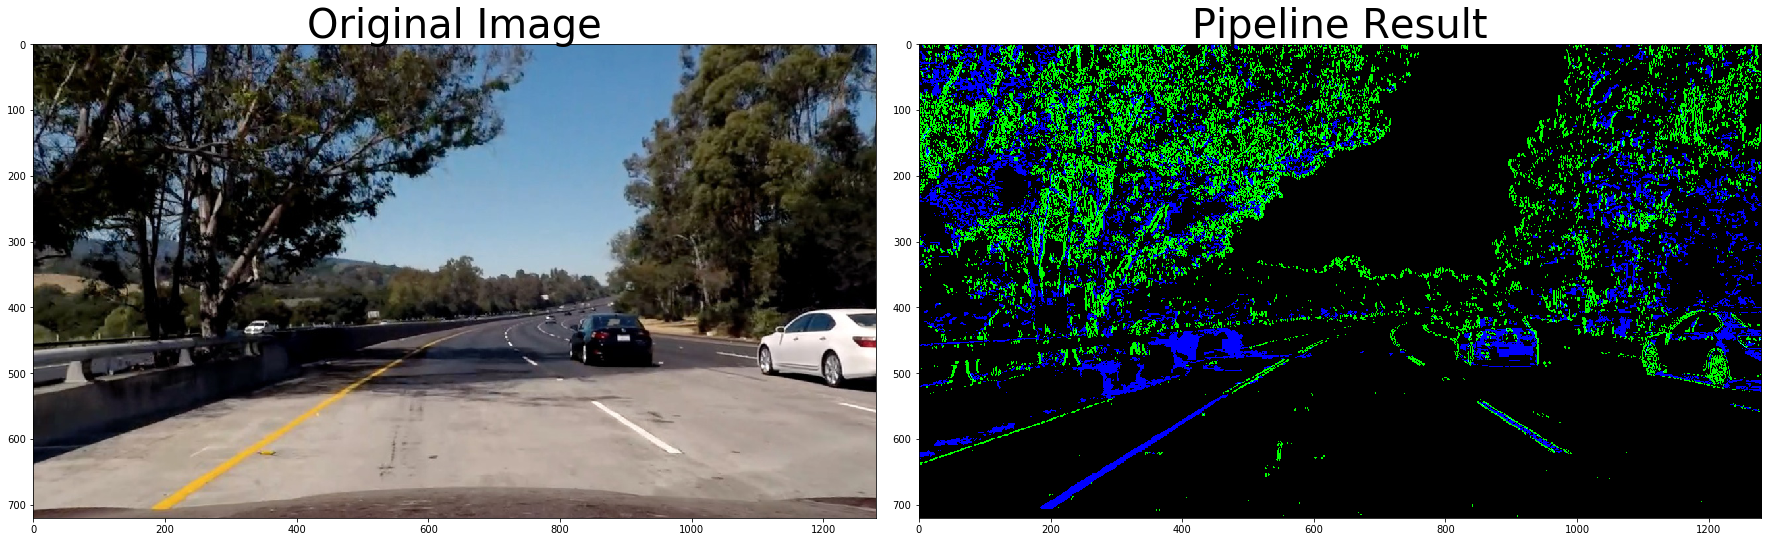

In [138]:

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 经过以上，颜色阈值过滤，边缘检测，畸变矫正，透视变换等方法，最后得到车道线图如下

![avatar](./images/lane_line_gray.png)

## 我们的目标还差最后一步，拟合处理

![avatar](./images/profit_lane_line.png)